# MSRE depletion with fission products removal rates
We will run a depletion simuation of the MSRE, introducing continuous removal rates to model fission products removal. 

**Note:** to run the following script this [branch](https://github.com/openmsr/openmc/tree/msr_13.2_cont) of OpenMC is needed.

In [1]:
%matplotlib inline

import openmc
import openmc.deplete
import numpy as np
from math import log10
import matplotlib.pyplot as plt
import os 

os.system('rm *.xml *.h5')

0

Let's start by defining materials and geometry in the same fashion of the other notebooks:

In [2]:
# Define materials 
hot_temp = 638.3 + 273.15 # in K
salt_density = 2.3275 # g/cm3
# Fuel salt 
salt = openmc.Material(name="salt", temperature = hot_temp)
salt.add_nuclide('Li6',1.31480070E-05)
salt.add_nuclide('Li7', 0.262960140146177)
salt.add_nuclide('Be9',1.1863E-01)
salt.add_nuclide('Zr90',1.0543E-02)
salt.add_nuclide('Zr91',2.2991E-03)
salt.add_nuclide('Zr92',3.5142E-03)
salt.add_nuclide('Zr94',3.5613E-03)
salt.add_nuclide('Zr96',5.7375E-04)
salt.add_nuclide('Hf174',8.3786E-10)
salt.add_nuclide('Hf176',2.7545E-08)
salt.add_nuclide('Hf177',9.7401E-08)
salt.add_nuclide('Hf178',1.4285E-07)
salt.add_nuclide('Hf179',7.1323E-08)
salt.add_nuclide('Hf180',1.8370E-07)
salt.add_nuclide('U234',1.034276246E-05)
salt.add_nuclide('U235',1.009695816E-03)
salt.add_nuclide('U236',4.227809892E-06)
salt.add_nuclide('U238',2.168267822E-03)
salt.add_nuclide('Fe54',2.8551E-06)
salt.add_nuclide('Fe56',4.4818E-05)
salt.add_nuclide('Fe57',1.0350E-06)
salt.add_nuclide('Fe58',1.3775E-07)
salt.add_nuclide('Cr50',2.1224E-06)
salt.add_nuclide('Cr52',4.0928E-05)
salt.add_nuclide('Cr53',4.6409E-06)
salt.add_nuclide('Cr54',1.1552E-06)
salt.add_nuclide('Ni58',5.8597E-06)
salt.add_nuclide('Ni60',2.2571E-06)
salt.add_nuclide('Ni61',9.8117E-08)
salt.add_nuclide('Ni62',3.1284E-07)
salt.add_nuclide('Ni64',7.9671E-08)
salt.add_nuclide('O16',5.1437E-04)
salt.add_nuclide('O17',1.8927E-07)
salt.add_nuclide('O18',9.6440E-07)
salt.add_nuclide('F19',5.9409E-01)
salt.set_density('g/cm3', salt_density)

#Moderator graphite block
graphite = openmc.Material(name='graphite', temperature = hot_temp)
graphite.set_density('g/cm3',1.86)
graphite.add_nuclide('C12',1)
graphite.add_s_alpha_beta('c_Graphite')

#inor-8
inor = openmc.Material(name='inor-8', temperature = hot_temp)
inor.set_density('g/cm3',8.7745)
inor.add_element('Ni',68.5,'wo')
inor.add_element('Mo',16.5,'wo')
inor.add_element('Cr',7,'wo')
inor.add_element('Fe',5,'wo')
inor.add_element('C',0.06,'wo')
inor.add_element('Al',0.25,'wo')
inor.add_element('Ti',0.25,'wo')
inor.add_element('S',0.02,'wo')
inor.add_element('Mn',1.0,'wo')
inor.add_element('Si',1.0,'wo')
inor.add_element('Cu',0.35,'wo')
inor.add_element('B',0.010,'wo')
inor.add_element('W',0.5,'wo')
inor.add_element('P',0.015,'wo')
inor.add_element('Co',0.2,'wo')

#helium
helium = openmc.Material(name='helium')
helium.add_element('He',1.0)
helium.set_density('g/cm3',1.03*(10**-4))

#Control rods inconel clad
trace = 0.01
inconel = openmc.Material(name='inconel', temperature = 65.6 + 273.15)
inconel.add_element('Ni',78.5,percent_type='wo')
inconel.add_element('Cr',14.0,percent_type='wo')
inconel.add_element('Fe',6.5,percent_type='wo')
inconel.add_element('Mn',0.25,percent_type='wo')
inconel.add_element('Si',0.25,percent_type='wo')
inconel.add_element('Cu',0.2,percent_type='wo')
inconel.add_element('Co',0.2,percent_type='wo')
inconel.add_element('Al',0.2,percent_type='wo')
inconel.add_element('Ti',0.2,percent_type='wo')
inconel.add_element('Ta',0.5,percent_type='wo')
inconel.add_element('W',0.5,percent_type='wo')
inconel.add_element('Zn',0.2,percent_type='wo')
inconel.add_element('Zr',0.1,percent_type='wo')
inconel.add_element('C',trace,percent_type='wo')
inconel.add_element('Mo',trace,percent_type='wo')
inconel.add_element('Ag',trace,percent_type='wo')
inconel.add_element('B',trace,percent_type='wo')
inconel.add_element('Ba',trace,percent_type='wo')
inconel.add_element('Be',trace,percent_type='wo')
inconel.add_element('Ca',trace,percent_type='wo')
inconel.add_element('Cd',trace,percent_type='wo')
inconel.add_element('V',trace,percent_type='wo')
inconel.add_element('Sn',trace,percent_type='wo')
inconel.add_element('Mg',trace,percent_type='wo')
inconel.set_density('g/cm3',8.5)

# SS316 control rod flexible hose
ss316 = openmc.Material(name='ss316', temperature = 65.6 + 273.15)
ss316.add_element('C',0.026,'wo')
ss316.add_element('Si',0.37,'wo')
ss316.add_element('Mn',0.16,'wo')
ss316.add_element('Cr',16.55,'wo')
ss316.add_element('Cu',0.16,'wo')
ss316.add_element('Ni',10,'wo')
ss316.add_element('P',0.029,'wo')
ss316.add_element('S',0.027,'wo')
ss316.add_element('Mo',2.02,'wo')
ss316.add_element('N',0.036,'wo')
ss316.add_element('Fe',70.622,'wo')
ss316.set_density('g/cm3',7.99)

#Control rods bushing posion material
Gd2O3 = openmc.Material()
Gd2O3.add_element('Gd',2)
Gd2O3.add_element('O',3)
Gd2O3.set_density('g/cm3',7.41)
Al2O3 = openmc.Material()
Al2O3.add_element('Al',2)
Al2O3.add_element('O',3)
Al2O3.set_density('g/cm3',3.95)
bush = openmc.Material.mix_materials([Gd2O3,Al2O3],[0.7,0.3],'wo')
bush.name='bush'
bush.temperature = 65.6 +273.15

#Concrete block
concrete = openmc.Material(name='concrete')
concrete.add_element('H',0.005,'wo')
concrete.add_element('O',0.496,'wo')
concrete.add_element('Si',0.314,'wo')
concrete.add_element('Ca',0.083,'wo')
concrete.add_element('Na',0.017,'wo')
concrete.add_element('Mn',0.002,'wo')
concrete.add_element('Al',0.046,'wo')
concrete.add_element('S',0.001,'wo')
concrete.add_element('K',0.019,'wo')
concrete.add_element('Fe',0.012,'wo')
concrete.set_density('g/cm3',2.35)

#Thermal shielding as material mix of water and SS304 50-50 vo
water = openmc.Material()
water.add_element('H',2)
water.add_element('O',1)
water.set_density('g/cm3',0.997)

#stainless steel 304
ss304 =  openmc.Material()
ss304.add_element('C',0.08,'wo')
ss304.add_element('Mn',2,'wo')
ss304.add_element('P',0.045,'wo')
ss304.add_element('S',0.03,'wo')
ss304.add_element('Si',0.75,'wo')
ss304.add_element('Cr',19,'wo')
ss304.add_element('Ni',10,'wo')
ss304.add_element('N',0.1,'wo')
ss304.add_element('Fe',67.995, 'wo')
ss304.set_density('g/cm3',7.93)
shield = openmc.Material.mix_materials([water,ss304],[0.5,0.5],'vo')
shield.temperature = 32.2 + 273.15
shield.name='steelwater'

# "Careytemp 1600" by Philip Carey Manufacturing Compamy (Cincinnati) 
insulation=openmc.Material(name='insulation')
insulation.add_element('Si',1)
insulation.add_element('O',2)
insulation.set_density('g/cm3',0.16) 

# Sand water (not sure about this material)
sandwater=openmc.Material(name='sandwater')
sandwater.add_element('Fe',3)
sandwater.add_element('O',4)
sandwater.set_density('g/cm3',6)

#Vessel anular steel
steel = openmc.Material(name='steel')
steel.add_element('Fe',1)
steel.set_density('g/cm3',7.85)

mats = openmc.Materials([salt,graphite,inor,helium,inconel,shield,concrete,steel,ss316,sandwater,insulation,bush])

In [3]:
# Import h5m files
core_h5m = '../h5m/msre_reactor_1e-2.h5m'
cr_h5m = '../h5m/msre_control_rod_1e-2.h5m'

# Create DAGMC universes out of h5m files
core = openmc.DAGMCUniverse(filename=core_h5m, auto_geom_ids=True, universe_id=1)
cr = openmc.DAGMCUniverse(filename=cr_h5m, auto_geom_ids=True, universe_id=2)

# Create regions
core_region = core.bounding_region()
cr1_region = cr.bounding_region(boundary_type='transmission', starting_id=20000)

# Extend control rod region, to include upwards translations
cr1_region = cr1_region | cr1_region.translate([0,0,150])

# Create control rod region 2 and 3 as translated region of control rod 1
offset = 10.163255
cr2_region = cr1_region.translate([-offset,0,0])
cr3_region = cr1_region.translate([-offset,offset,0])

# Create openmc Cells 
core_cell = openmc.Cell(region=~(cr1_region | cr2_region | cr3_region) & core_region , fill=core)
cr1_cell = openmc.Cell(name='CR1', region=cr1_region, fill=cr)
cr2_cell = openmc.Cell(name='CR2', region=cr2_region, fill=cr)
cr3_cell = openmc.Cell(name='CR3', region=cr3_region, fill=cr)
    
#translate control rods at top position (fully withdrawn)
inch_to_cm = 2.54
start_pos = 19.2 #inches
top_pos = 51 #inches
setattr(cr1_cell, 'translation', [0, 0, start_pos + top_pos*inch_to_cm])
setattr(cr2_cell, 'translation', [-offset, 0, start_pos + top_pos*2.54])
setattr(cr3_cell, 'translation', [-offset, offset, start_pos + top_pos*2.54])

# Create openmc Geometry object
geometry = openmc.Geometry([core_cell,cr1_cell,cr2_cell,cr3_cell])

In [4]:
settings = openmc.Settings()
settings.temperature = {'method':'interpolation','range':(293.15,923.15)}
settings.batches = 50
settings.inactive = 20
settings.particles = 30000
settings.photon_transport = False
source_area = openmc.stats.Box([-100., -100., 0.],[ 100.,  100.,  200.],only_fissionable = True)
settings.source = openmc.Source(space=source_area)

First of all, we will set up and run a standard depletion analysis that will be used as the reference to compare with the next case.

Let's define some general settings (timestep, power, depletable volume, integration scheme) and run the analysis:

In [5]:
model = openmc.model.Model(geometry,mats,settings)

#Depletion general settings
depletion_days = [5,5,30,30,30,180,95]
power = 8e6 #total thermal power [W]
salt_mass = 4590 * 10**3 #grams
salt_volume =salt_mass/salt_density #cm3
salt.volume = salt_volume

# Initialize depletion operator
op = openmc.deplete.CoupledOperator(model, normalization_mode = "energy-deposition", chain_file='ENDF-B-VIII.0_chain_msr.xml')

# Initialize integrator object and start depletion calculation 
integrator = openmc.deplete.CECMIntegrator(op, depletion_days, timestep_units='d', power=power)
integrator.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading Hf176 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Hf176.h5
 Reading Hf177 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Hf177.h5
 Reading Hf178 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Hf178.h5
 Reading Hf179 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Hf179.h5
 Reading Hf180 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Hf180.h5
 Reading U234 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/U234.h5
 Reading U235 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/U235.h5
 Reading U236 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/U236.h5
 Reading U238 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/U238.h5
 Reading C12 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/C12.h5
 Reading B10 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/B10.h5
 Reading B11 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/B11.h5
 Reading C13 from /home/lorenzo/Documents/cross_

          1200K


 Reading Cd112 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Cd112.h5
 Reading Cd113 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Cd113.h5
 Reading Cd114 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Cd114.h5
 Reading Cd116 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Cd116.h5
 Reading Sn112 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Sn112.h5
 Reading Sn114 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Sn114.h5
 Reading Sn115 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Sn115.h5
 Reading Sn116 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Sn116.h5
 Reading Sn117 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Sn117.h5
 Reading Sn118 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Sn118.h5
 Reading Sn119 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Sn119.h5
 Reading Sn120 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Sn120.h5
 Reading Sn122 from /home/lo

 Reading Si31 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Si31.h5
 Reading Si32 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Si32.h5
 Reading S35 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/S35.h5
 Reading Cl35 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Cl35.h5
 Reading Cl36 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Cl36.h5
 Reading Cl37 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Cl37.h5
 Reading Ar36 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Ar36.h5
 Reading Ar37 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Ar37.h5


 Reading Ar38 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Ar38.h5
 Reading Ar39 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Ar39.h5
 Reading Ar40 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Ar40.h5
 Reading Ar41 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Ar41.h5
 Reading Ca41 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Ca41.h5
 Reading Ca45 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Ca45.h5
 Reading Ca47 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Ca47.h5
 Reading Sc45 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Sc45.h5
 Reading V49 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/V49.h5
 Reading Cr51 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Cr51.h5
 Reading Mn54 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Mn54.h5
 Reading Fe55 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Fe55.h5
 Reading Co58 from /home/lorenzo/Documents/cross_secti

 Reading Se81 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Se81.h5
 Reading Se82 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Se82.h5
 Reading Br79 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Br79.h5
 Reading Br80 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Br80.h5
 Reading Br81 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Br81.h5
 Reading Kr78 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Kr78.h5
 Reading Kr79 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Kr79.h5
 Reading Kr80 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Kr80.h5
 Reading Kr81 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Kr81.h5
 Reading Kr82 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Kr82.h5
 Reading Kr83 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Kr83.h5
 Reading Kr84 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Kr84.h5
 Reading Kr85 from /home/lorenzo/Documents/cross_sec

 Reading Nb95 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Nb95.h5
 Reading Mo93 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Mo93.h5
 Reading Mo99 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Mo99.h5


 Reading Tc98 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Tc98.h5
 Reading Tc99 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Tc99.h5
 Reading Ru96 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Ru96.h5
 Reading Ru97 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Ru97.h5
 Reading Ru98 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Ru98.h5
 Reading Ru99 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Ru99.h5
 Reading Ru100 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Ru100.h5
 Reading Ru101 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Ru101.h5
 Reading Ru102 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Ru102.h5
 Reading Ru103 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Ru103.h5
 Reading Ru104 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Ru104.h5
 Reading Ru105 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Ru105.h5
 Reading Ru106 from /home/lorenzo/Docume

          250K
          294K
          600K
          900K
          1200K
          2500K


 Reading Cd109 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Cd109.h5
 Reading Cd115_m1 from
 /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Cd115_m1.h5
 Reading In113 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/In113.h5
 Reading In114 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/In114.h5
 Reading In115 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/In115.h5
 Reading Sn113 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Sn113.h5
 Reading Sn121_m1 from
 /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Sn121_m1.h5
 Reading Sn123 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Sn123.h5
 Reading Sn125 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Sn125.h5
 Reading Sn126 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Sn126.h5


          1200K
          2500K


 Reading Sb121 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Sb121.h5
 Reading Sb122 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Sb122.h5
 Reading Sb123 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Sb123.h5
 Reading Sb124 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Sb124.h5
 Reading Sb125 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Sb125.h5
 Reading Sb126 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Sb126.h5
 Reading Te120 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Te120.h5
 Reading Te121 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Te121.h5


          1200K
          2500K


 Reading Te121_m1 from
 /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Te121_m1.h5
 Reading Te122 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Te122.h5
 Reading Te123 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Te123.h5
 Reading Te124 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Te124.h5
 Reading Te125 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Te125.h5
 Reading Te126 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Te126.h5
 Reading Te127_m1 from
 /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Te127_m1.h5
 Reading Te128 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Te128.h5
 Reading Te129_m1 from
 /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Te129_m1.h5
 Reading Te130 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Te130.h5
 Reading Te131 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Te131.h5
 Reading Te131_m1 from
 /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Te131_m1.h5


 Reading I132_m1 from
 /home/lorenzo/Documents/cross_sections/endfb80_hdf5/I132_m1.h5
 Reading I133 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/I133.h5
 Reading I134 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/I134.h5
 Reading I135 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/I135.h5
 Reading Xe123 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Xe123.h5
 Reading Xe124 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Xe124.h5
 Reading Xe125 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Xe125.h5
 Reading Xe126 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Xe126.h5
 Reading Xe127 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Xe127.h5
 Reading Xe128 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Xe128.h5
 Reading Xe129 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Xe129.h5
 Reading Xe130 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Xe130.h5
 Reading Xe131 from /home/lor

          2500K


 Reading Cs134 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Cs134.h5
 Reading Cs135 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Cs135.h5
 Reading Cs136 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Cs136.h5
 Reading Cs137 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Cs137.h5
 Reading Ba131 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Ba131.h5


          1200K
          2500K


 Reading Ba133 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Ba133.h5
 Reading Ba139 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Ba139.h5
 Reading Ba140 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Ba140.h5
 Reading La138 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/La138.h5
 Reading La139 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/La139.h5
 Reading La140 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/La140.h5
 Reading Ce136 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Ce136.h5
 Reading Ce137 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Ce137.h5
 Reading Ce137_m1 from
 /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Ce137_m1.h5
 Reading Ce138 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Ce138.h5
 Reading Ce139 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Ce139.h5
 Reading Ce140 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Ce140.h5
 Reading Ce141 from /

          1200K
          2500K


 Reading Gd153 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Gd153.h5
 Reading Gd159 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Gd159.h5
 Reading Tb158 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Tb158.h5
 Reading Tb159 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Tb159.h5
 Reading Tb160 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Tb160.h5
 Reading Tb161 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Tb161.h5
 Reading Dy154 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Dy154.h5
 Reading Dy155 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Dy155.h5
 Reading Dy156 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Dy156.h5
 Reading Dy157 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Dy157.h5
 Reading Dy158 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Dy158.h5
 Reading Dy159 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Dy159.h5
 Reading Dy160 from /home/lo

          1200K
          2500K


 Reading Yb169 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Yb169.h5
 Reading Yb170 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Yb170.h5
 Reading Yb171 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Yb171.h5
 Reading Yb172 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Yb172.h5
 Reading Yb173 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Yb173.h5


          1200K
          2500K
          1200K
          2500K
          1200K
          2500K
          1200K
          2500K


 Reading Yb174 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Yb174.h5
 Reading Yb175 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Yb175.h5


          1200K
          2500K


 Reading Yb176 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Yb176.h5
 Reading Lu175 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Lu175.h5
 Reading Lu176 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Lu176.h5
 Reading Hf175 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Hf175.h5


          1200K
          2500K


 Reading Hf181 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Hf181.h5
 Reading Hf182 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Hf182.h5
 Reading Ta182 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Ta182.h5
 Reading W181 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/W181.h5


          1200K
          2500K
          1200K
          2500K


 Reading W185 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/W185.h5
 Reading Re185 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Re185.h5
 Reading Re186_m1 from
 /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Re186_m1.h5
 Reading Re187 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Re187.h5
 Reading Os184 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Os184.h5
 Reading Os185 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Os185.h5
 Reading Os186 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Os186.h5
 Reading Os187 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Os187.h5
 Reading Os188 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Os188.h5
 Reading Os189 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Os189.h5
 Reading Os190 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Os190.h5
 Reading Os191 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Os191.h5
 Reading Os192 from /ho

 Reading Cm241 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Cm241.h5
 Reading Cm242 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Cm242.h5
 Reading Cm243 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Cm243.h5
 Reading Cm244 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Cm244.h5
 Reading Cm245 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Cm245.h5
 Reading Cm246 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Cm246.h5
 Reading Cm247 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Cm247.h5
 Reading Cm248 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Cm248.h5
 Reading Cm249 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Cm249.h5
 Reading Cm250 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Cm250.h5
 Reading Bk245 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Bk245.h5
 Reading Bk246 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Bk246.h5
 Reading Bk247 from /home/lo

          1200K


 Reading Cf254 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Cf254.h5
 Reading Es251 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Es251.h5
 Reading Es252 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Es252.h5
 Reading Es253 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Es253.h5
 Reading Es254 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Es254.h5
 Reading Es254_m1 from
 /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Es254_m1.h5
 Reading Es255 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Es255.h5
 Reading Fm255 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Fm255.h5
Timestep: 0 --> keff: 1.00505
[openmc.deplete] t=432000.0 s, dt=432000 s, source=8000000.0
Timestep: 1 --> keff: 0.99648
[openmc.deplete] t=864000.0 s, dt=2592000 s, source=8000000.0
Timestep: 2 --> keff: 0.99569
[openmc.deplete] t=3456000.0 s, dt=2592000 s, source=8000000.0
Timestep: 3 --> keff: 0.99108
[openmc.deplete] t=6048000.0 s, dt=2592

In [6]:
# Let's store some results that will be used later for comparison
results = openmc.deplete.Results('depletion_results.h5')
t, k_ref = results.get_keff()
n_xe_ref = 0
n_kr_ref = 0
for nuc,_ in openmc.data.isotopes('Xe'):
    n_xe_ref += results.get_atoms(str(salt.id), nuc)[1]
for nuc,_ in openmc.data.isotopes('Kr'):
    n_kr_ref += results.get_atoms(str(salt.id), nuc)[1]

# Removal rates theory
The possibility to remove fission products from the fuel salt is one of the key characteristics of the MSRE and msr reactor in general. 

Mathematically nuclides removal can be thought as an additional term to the Bateman equation:

$\frac{dn_i(t)}{dt} = \underbrace{\sum_j \gamma_{j\rightarrow i} n_j\overline{\sigma_j\phi} - n_i \overline{\sigma_i \phi}}_\textbf{R}  + \underbrace{\sum_j \gamma_{j\rightarrow i} n_j\lambda_{i\rightarrow j} + \lambda_{j\rightarrow i}n_i}_\textbf{D} - \underbrace{\epsilon_i \lambda_i n_i}_\textbf{T}$,

Where $ \epsilon_i \lambda_i n_i $ is the removal term, $\epsilon_i$ is the removal efficiency and
$\lambda_i$ is the removal rate coefficient for the continuous removal of the nuclide $i$, expressed in ($s^{-1}$) units.

Another way to characterize $\lambda_i$ is through the concept of cycle time: $T_{cyc,i} = \frac{1}{\lambda_i}$, as the time needed to process the removal elements at a specific volumetric rate.

For simplicity, we can combine $\epsilon_i$ and $\lambda_i$ in one single parameter, that we can call again $\lambda_i$. Thus, setting a removal rate coefficient of, for example, $1\ (s^{-1})$ at $100\ \%$ efficiency is the same as setting $10\ (s^{-1})$ at $10\ \%$.

The capability to model removal rates has been deployed under a different [branch](https://github.com/openmsr/openmc/tree/msr_13.2_cont) of OpenMC.

In this example we will set removal rates to gasseous fission products, Xe and Kr, and noble metals fission products. The values and their explanation can be found [here](https://info.ornl.gov/sites/publications/Files/Pub173113.pdf)


In [8]:
# Re-initialize depletion operator
op = openmc.deplete.CoupledOperator(model, normalization_mode = "energy-deposition", chain_file='ENDF-B-VIII.0_chain_msr.xml')

# Initialize msr continuous object
msr = openmc.deplete.msr.MsrContinuous(op, model)

# Set removal rates constants in 1/s
msr.set_removal_rate('salt', ['Xe','Kr'], 4.067e-5)
msr.set_removal_rate('salt', ['Se','Nb','Mo','Tc','Ru','Rh','Pd','Ag','Sb','Te'], 8.777e-3)

# Initialize integrator object and start depletion calculation 
integrator = openmc.deplete.CECMIntegrator(op, depletion_days, msr_continuous=msr, timestep_units='d', power=power)
integrator.integrate()

[openmc.deplete] t=0.0 s, dt=432000 s, source=8000000.0
Timestep: 0 --> keff: 1.00478


[openmc.deplete] t=432000.0 s, dt=432000 s, source=8000000.0
Timestep: 1 --> keff: 1.00248


[openmc.deplete] t=864000.0 s, dt=2592000 s, source=8000000.0
Timestep: 2 --> keff: 1.00147
[openmc.deplete] t=3456000.0 s, dt=2592000 s, source=8000000.0
Timestep: 3 --> keff: 0.99758
[openmc.deplete] t=6048000.0 s, dt=2592000 s, source=8000000.0


Timestep: 4 --> keff: 0.99451
[openmc.deplete] t=8640000.0 s, dt=15552000 s, source=8000000.0
Timestep: 5 --> keff: 0.99462
[openmc.deplete] t=24192000.0 s, dt=8208000 s, source=8000000.0
Timestep: 6 --> keff: 0.98593
[openmc.deplete] t=32400000.0 (final operator evaluation)


# Critical Factor
As we've set removal rates to fission products, we except keff to drop less rapidly than in the first case, let's verify that: 

In [17]:
results = openmc.deplete.Results('depletion_results.h5')
t, k = results.get_keff()
n_xe = 0
n_kr = 0
for nuc,_ in openmc.data.isotopes('Xe'):
    n_xe += results.get_atoms(str(salt.id), nuc)[1]
for nuc,_ in openmc.data.isotopes('Kr'):
    n_kr += results.get_atoms(str(salt.id), nuc)[1]

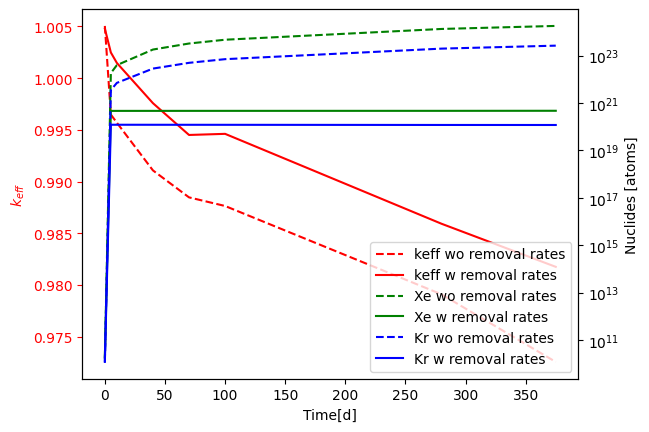

In [18]:
# Let's convert time from sec to days 
t /= (3600 * 24)

plt.figure()
ax = plt.subplot()
k1, = ax.plot(t, [k[0] for k in k_ref], '--', c='red', label='keff wo removal rates')
k2, = ax.plot(t, [k[0] for k in k], c='red', label='keff w removal rates')
ax1 = ax.twinx()
n1, = ax1.plot(t, n_xe_ref, '--', c='green', label='Xe wo removal rates')
n2, = ax1.plot(t, n_xe, c='green', label='Xe w removal rates')
n3, = ax1.plot(t, n_kr_ref, '--', c='blue', label='Kr wo removal rates')
n4, = ax1.plot(t, n_kr, c='blue', label='Kr w removal rates')
ax.set_xlabel('Time[d]')
ax.set_ylabel(r'$k_{eff}$', color='r')
ax.tick_params(axis='y', colors='red')
ax1.set_yscale('log')
ax1.set_ylabel('Nuclides [atoms]')
ax1.legend(handles=[k1, k2, n1, n2, n3, n4])
plt.show()

# Fission products
The removal rate for gaseous fission products has been tuned (see [here](https://info.ornl.gov/sites/publications/Files/Pub173113.pdf)) to obtain a Xenon poison fractions matching the measurements reported during the MSRE U235 operation, of 0.3%-0.4%. 

The Xenon poison fraction is defined as:
$FP = \frac{\Sigma_a^{135}Xe}{\Sigma_a^{235}U}$

Let's plot the same quantity and see if we obtain values that matches the reference :

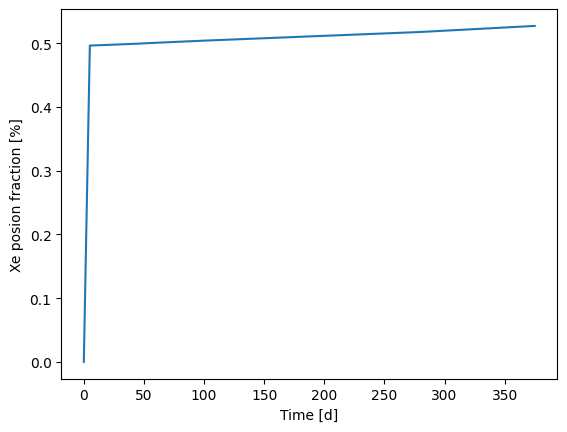

In [21]:
# Microscopic absorption cross section at 0.0253 eV
xs_xe135 = 2664214.0
xs_u235 = 686.006994850397
_, n_xe135 = results.get_atoms(str(salt.id), 'Xe135')
_, n_u235 = results.get_atoms(str(salt.id), 'U235')
# Poison fraction
pf = (xs_xe135*n_xe135)/(xs_u235*n_u235)*100
plt.figure()
plt.plot(t, pf)
plt.xlabel('Time [d]')
plt.ylabel('Xe posion fraction [%]')
plt.show()

# Inventory 


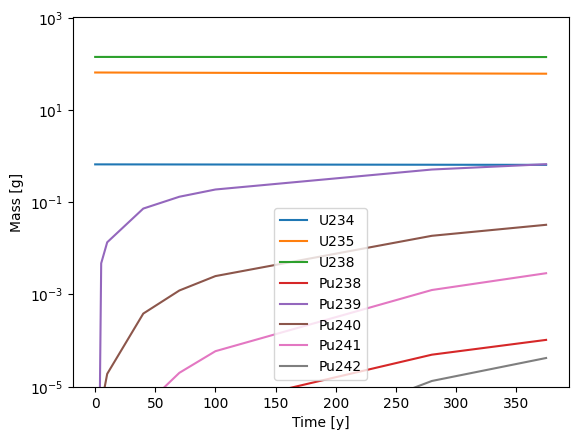

In [22]:
inventory = dict()
for nuc,_ in openmc.data.isotopes('U'):
    inventory[nuc] = results.get_atoms(str(salt.id), nuc)[1] / openmc.data.AVOGADRO * openmc.data.atomic_mass(nuc) / 1000

for nuc in ['Pu238','Pu239','Pu240','Pu241','Pu242']:
    inventory[nuc] = results.get_atoms(str(salt.id), nuc)[1] / openmc.data.AVOGADRO * openmc.data.atomic_mass(nuc) / 1000

plt.figure()
for nuc, mass in inventory.items():
    plt.plot(t, mass, label=nuc)
plt.xlabel('Time [y]')
plt.ylabel('Mass [g]')
plt.yscale('log')
plt.ylim(1e-5)
plt.legend()
plt.show()

# Neutron absorption in the fuel

In [23]:
import re
import seaborn as sns
regex = re.compile(r'(\d+|\s+)')

# All nuclides present in the fuel at last time-step
nucs = results.export_to_materials(-1)[0].get_nuclides()

# Let's begin by making some useful groupings
gaseos = ['H', 'He', 'Ne', 'Ar', 'Kr', 'Xe', 'Rn'] #gaseous fission products
noble_metals = ['Se','Nb','Mo','Tc','Ru','Rh','Pd','Ag','Sb','Te'] # noble metals fission products
metals = ['Cr','Mn','Fe','Co','Ni','Cu','Zn','Hf','Zr','W',]
halogens = ['F','Cl','Br','I','At']
alkali_metals = ['Li','Na','K','Rb','Cs']
alkali_earths= ['Be','Mg','Ca','Sr','Ba','Ra']
lanthanides  = ['Y','La','Ce','Pr','Nd','Pm','Sm','Eu','Gd','Tb','Dy','Ho','Er','Tm','Yb','Lu']
m_a = ['Ac','Th','Pa','Np','Am','Cm','Bk','Cf','Es','Fm','Md','No','Lr']
# Get fissile nuclides in the fuel, based on Ronen's rule for determining fissile isotopes
fissile = []

for nuc in nucs:
    elm = regex.split(nuc)[0]
    a = round(openmc.data.atomic_mass(nuc))
    z = openmc.data.ATOMIC_NUMBER[elm]
    if 90 <= z <= 100:
        ronen = 2*z -(a-z)
        if ronen in [41,43,45]:
            fissile.append(nuc) 

# Calculate totat absorption rate of fissile nuclides
tot_abs_rate = 0
for nuc in fissile:
    tot_abs_rate += results.get_reaction_rate(str(salt.id), nuc, 'fission')[1]
    tot_abs_rate += results.get_reaction_rate(str(salt.id), nuc, '(n,gamma)')[1]

nuclides_stack = dict()
groups_stack = {'Gaseos':0, 'Noble metals':0, 'Metals':0, 'Halogens':0 , 'Alkali metals':0, 'Alkali earths':0, 'Lanthanides':0, 'MA':0, 'Others':0}
for nuc in nucs:
    
    if regex.split(nuc)[0] in ['U','Pu']:
        nuclides_stack[nuc] = results.get_reaction_rate(str(salt.id), nuc, 'fission')[1]
        nuclides_stack[nuc] += results.get_reaction_rate(str(salt.id), nuc, '(n,gamma)')[1]
        nuclides_stack[nuc] /= tot_abs_rate
        
        
    elif regex.split(nuc)[0] in gaseos:
        groups_stack['Gaseos'] += results.get_reaction_rate(str(salt.id), nuc, 'fission')[1]
        groups_stack['Gaseos'] += results.get_reaction_rate(str(salt.id), nuc, '(n,gamma)')[1]
    elif regex.split(nuc)[0] in noble_metals:
        groups_stack['Noble metals'] += results.get_reaction_rate(str(salt.id), nuc, 'fission')[1]
        groups_stack['Noble metals'] += results.get_reaction_rate(str(salt.id), nuc, '(n,gamma)')[1]
    elif regex.split(nuc)[0] in metals:
        groups_stack['Metals'] += results.get_reaction_rate(str(salt.id), nuc, 'fission')[1]
        groups_stack['Metals'] += results.get_reaction_rate(str(salt.id), nuc, '(n,gamma)')[1]
    elif regex.split(nuc)[0] in halogens:
        groups_stack['Halogens'] += results.get_reaction_rate(str(salt.id), nuc, 'fission')[1]
        groups_stack['Halogens'] += results.get_reaction_rate(str(salt.id), nuc, '(n,gamma)')[1]
    elif regex.split(nuc)[0] in alkali_metals:
        groups_stack['Alkali metals'] += results.get_reaction_rate(str(salt.id), nuc, 'fission')[1]
        groups_stack['Alkali metals'] += results.get_reaction_rate(str(salt.id), nuc, '(n,gamma)')[1]
    elif regex.split(nuc)[0] in alkali_earths:
        groups_stack['Alkali earths'] += results.get_reaction_rate(str(salt.id), nuc, 'fission')[1]
        groups_stack['Alkali earths'] += results.get_reaction_rate(str(salt.id), nuc, '(n,gamma)')[1]
    elif regex.split(nuc)[0] in lanthanides:
        groups_stack['Lanthanides'] += results.get_reaction_rate(str(salt.id), nuc, 'fission')[1]
        groups_stack['Lanthanides'] += results.get_reaction_rate(str(salt.id), nuc, '(n,gamma)')[1]
    elif regex.split(nuc)[0] in m_a:
        groups_stack['MA'] += results.get_reaction_rate(str(salt.id), nuc, 'fission')[1]
        groups_stack['MA'] += results.get_reaction_rate(str(salt.id), nuc, '(n,gamma)')[1]
    else:
        groups_stack['Others'] += results.get_reaction_rate(str(salt.id), nuc, 'fission')[1]
        groups_stack['Others'] += results.get_reaction_rate(str(salt.id), nuc, '(n,gamma)')[1]

# Divide each array by the total absorption reaction rate of fissile nuclides
for g in groups_stack.keys():
    groups_stack[g] /= tot_abs_rate

# Sort dictionary groups
groups_stack=dict(reversed(sorted(groups_stack.items(), key=lambda item: item[1][len(item)])))

# Create red color palette for groups_stack
colors = list(reversed(sns.color_palette("Reds", len(groups_stack))))

# Order uranium series
u_series = {key:value for key,value in nuclides_stack.items() if key.startswith('U')}
u_series = dict(reversed(sorted(u_series.items(), key=lambda item: item[1][len(item)])))
# Create green color palette for Uranium isotopes
colors += list(reversed(sns.color_palette("Greens", len(u_series))))

# Order plutionium series
pu_series = {key:value for key,value in nuclides_stack.items() if key.startswith('Pu')}
pu_series = dict(reversed(sorted(pu_series.items(), key=lambda item: item[1][len(item)])))
# Create blue color palette for plutonium isotopes
colors += list(reversed(sns.color_palette("Blues", len(pu_series))))
# Add uramium and plutonium series to the stack
groups_stack.update(u_series)
groups_stack.update(pu_series)

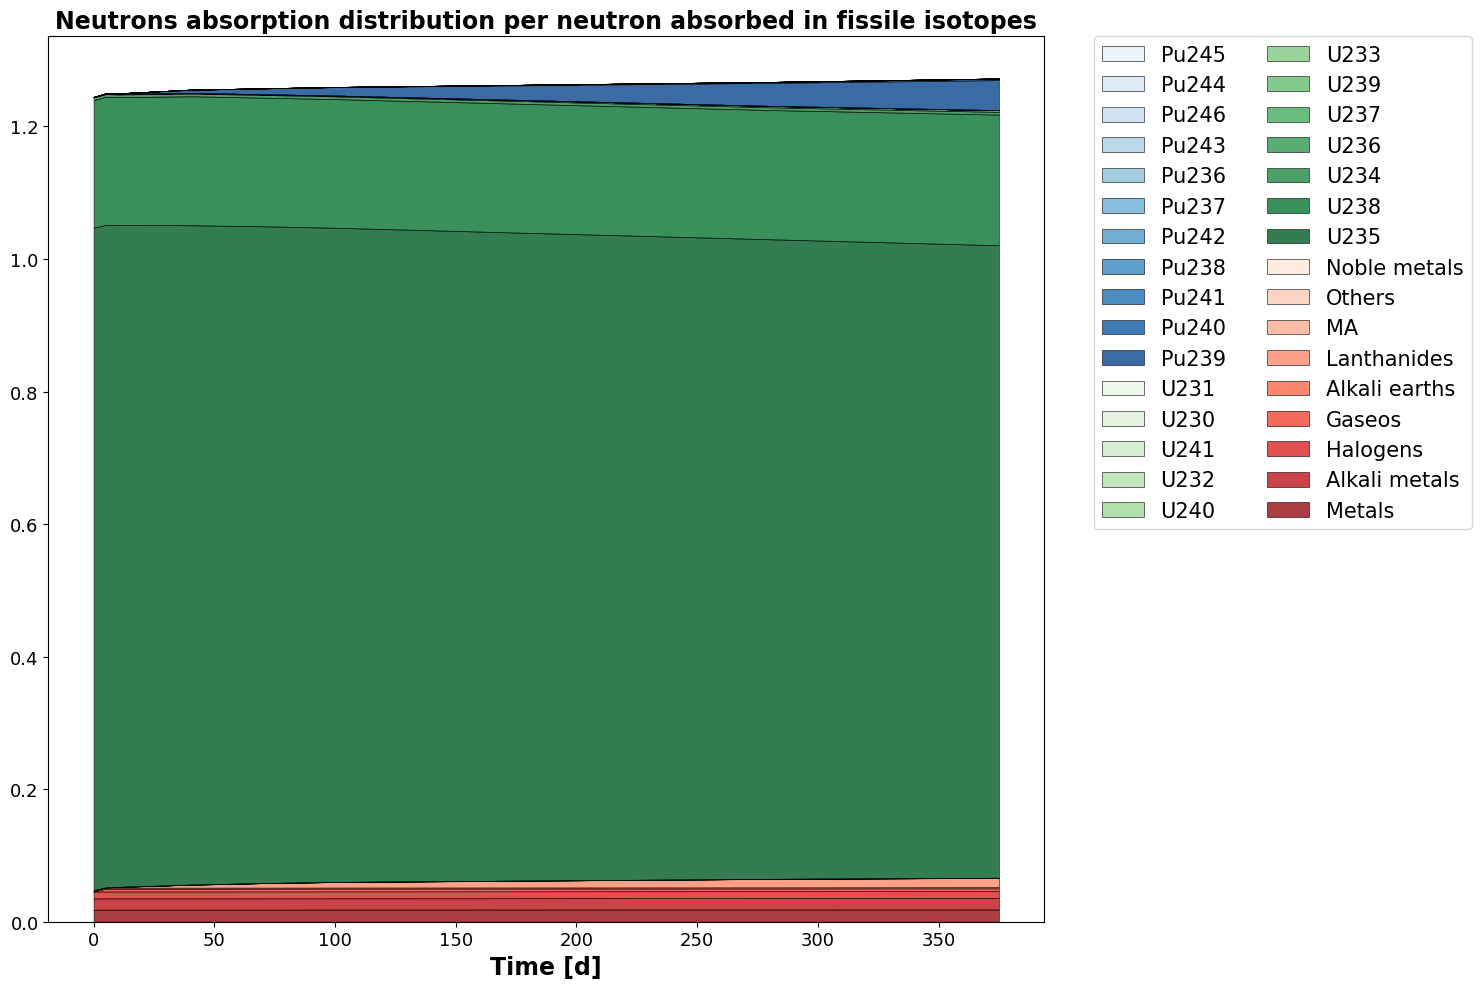

In [24]:
plt.figure(figsize=(15,10))
plt.stackplot(t, groups_stack.values(), labels=groups_stack.keys(), 
              edgecolor="black", linewidth=0.5,colors=colors, alpha=0.8)
handles, labels = plt.gca().get_legend_handles_labels()
legend = plt.legend([handles[idx] for idx in list(reversed(np.arange(0,len(handles),1)))],
                            [labels[idx] for idx in list(reversed(np.arange(0,len(handles),1)))],
                            bbox_to_anchor=(1.05,1), loc='upper left',
                            borderaxespad=0, ncol=2,
                            fontsize=15)
plt.xlabel('Time [d]',weight='bold',fontsize=17)
plt.title('Neutrons absorption distribution per neutron absorbed in fissile isotopes',
                   weight='bold', fontsize=17)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
plt.show()

Here we can visualize the neutrons absorption for each nuclide present in the fuel per neutrons absorption by fissile isotopes. In other words we can see, out of the total neutrons generated, where and how many we end up losing.

It is useful to group together those isotopes with similar characteristics that individually wouldn't represent a big contribution to capture.

Due to the low burnup and relatively short simulation time, we are far from equilibrium. However, we can notice the quick increase of absorption in the Pu isotopes, created from neutron capture of U238, and in particular of Pu239, due to its higher absorption cross section than U235.

**Note**: Neutrons lost to leakage out of the core and capture in other isotopes other than fuel are not represented. Thus, approximately 1 neutron is missing from the counting (we know that a fission event releases approximately 2.3 neutrons). This is simply due to the fact that we have defined the fuel salt as our only depletable material.